# ДЗ1 Елизаров Константин, MADE-DS-31

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import itertools
from tqdm import tqdm

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
1. численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
2. туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть **usable ace**), и за 1 очко, если превосходит;
3. игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
4. игрок может совершать одно из двух действий: **hit**  — взять ещё одну карту, **stand** — не брать больше карт;
5. если сумма очков у игрока на руках больше 21, он проигрывает (**bust**);
6. если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
7. после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
8. в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

**Задание:**
1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [2]:
def get_episode(env, policy):
    """Simulate one Blackjack episode"""
    state = env.reset()
    finish = False
    G = 0
    
    while not finish:
        index = state_to_index[state]
        action = policy[index]
        new_state, reward, finish, _ = env.step(action)
        state = new_state
        G += reward
        
    return G

def get_mean_reward(env, policy, n_steps = 500000, verbose=True):
    """Compute mean reward through episodes"""
    rewards = []
    
    for _ in tqdm(range(n_steps), disable=not verbose):
        G = get_episode(env, policy)
        rewards.append(G)
        
    return np.mean(rewards)

In [3]:
env = gym.make('Blackjack-v1')
env.natural = True
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Пространство состояний включает недостижимые состояния:

1. Сумма очков карт игрока колеблется от 0 ... 31 (0 ... 3 недостижимы)
2. Очки открытой карты дилера варьируются от 0 до 10 (0 недостижим)
3. Usable ace находится в диапазоне от 0 до 1 (все достижимы)

In [4]:
actions = (0, 1)

# Заранее выкинем недостижимые состояния
states = list(itertools.product(range(4, 32), range(1, 11), (False, True)))
states = [i for i in states if not (i[0] < 12 and i[2])]
states = [i for i in states if not (i[0] > 21 and i[2])]
state_to_index = {s: i for i, s in enumerate(states)}

# Стратегия - говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, 
# во всех остальных случаях говорить hit.
simple_policy = {i: 0 if s[0] in [19, 20, 21] else 1 for i, s in enumerate(states)}

Оценим выигрыш от этой стратегии, используя методы Монте-Карло.

In [5]:
rew = get_mean_reward(env, simple_policy)
print(f'Выигрыш при использовании стратегии "stand when 19, 20, 21": {rew}')

100%|██████████| 500000/500000 [00:22<00:00, 22478.59it/s]

Выигрыш при использовании стратегии "stand when 19, 20, 21": -0.198364


In [3]:
def get_policy_by_Q(Q):
    """Get optimal policy by Q matrix"""
    return np.argmax(Q, axis=1)

def q_learning_episode(env, actions, Q, alpha=0.1, eps=0.1, gamma=0.9):
    """Make one Q-learning episode"""
    state = env.reset()
    index = state_to_index[state]
    finish = False
    
    while not finish:
        action = np.argmax(Q[index]) if np.random.random() < (1 - eps) else np.random.choice(actions)
        new_state, reward, finish, _ = env.step(action)
        new_index = state_to_index[new_state]
        Q[index, action] = (1 - alpha) * Q[index, action] + alpha * (reward + gamma * np.max(Q[new_index]))
        state, index = new_state, new_index
        
    return Q
    

def q_learning(env, actions, Q, n_steps=100000, alpha=0.1, eps=0.1, gamma=0.9, verbose=True):
    """Q-learning cycle"""
    for _ in tqdm(range(n_steps), disable=not verbose):
        Q = q_learning_episode(env, actions, Q, alpha, eps, gamma)
        
    return Q

Реализуем метод обучения с подкреплением без модели ($\epsilon$-greedy Q-learning).

In [7]:
Q = np.zeros((len(states), len(actions)))

Q = q_learning(env, actions, Q, n_steps=300000)
q_policy = get_policy_by_Q(Q)
rew = get_mean_reward(env, q_policy)
print(f'Выигрыш при использовании стратегии, обученной из Q-learning: {rew}')

100%|██████████| 500000/500000 [00:23<00:00, 21379.05it/s]

Выигрыш при использовании стратегии, обученной из Q-learning: -0.13435


Подберем оптимальные гиперпараметры **alpha** и **epsilon**.

In [8]:
alphas = np.array([0.00001, 0.00002, 0.00003, 0.00005])
alpha_list = np.hstack([alphas, 10 * alphas, 100 * alphas])

for alpha in alpha_list:
    Q = np.zeros((len(states), len(actions)))
    Q = q_learning(env, actions, Q, n_steps=100000, alpha=alpha, verbose=False)
    q_policy = get_policy_by_Q(Q)
    rew = get_mean_reward(env, q_policy, n_steps=100000, verbose=False)
    print(f'Alpha = {alpha:.5f}, reward = {rew}')
    

Alpha = 0.00001, reward = -0.06791
Alpha = 0.00002, reward = -0.07966
Alpha = 0.00003, reward = -0.08498
Alpha = 0.00005, reward = -0.08594
Alpha = 0.00010, reward = -0.07539
Alpha = 0.00020, reward = -0.07114
Alpha = 0.00030, reward = -0.08026
Alpha = 0.00050, reward = -0.06685
Alpha = 0.00100, reward = -0.09047
Alpha = 0.00200, reward = -0.09648
Alpha = 0.00300, reward = -0.12106
Alpha = 0.00500, reward = -0.13531


In [9]:
eps_list = np.arange(0, 1.05, 0.05)

for eps in eps_list:
    Q = np.zeros((len(states), len(actions)))
    Q = q_learning(env, actions, Q, n_steps=100000, alpha=0.00001, eps=eps, verbose=False)
    q_policy = get_policy_by_Q(Q)
    rew = get_mean_reward(env, q_policy, n_steps=100000, verbose=False)
    print(f'Epsilon = {eps:.2f}, reward = {rew}')

Epsilon = 0.00, reward = -0.0746
Epsilon = 0.05, reward = -0.08368
Epsilon = 0.10, reward = -0.09016
Epsilon = 0.15, reward = -0.06682
Epsilon = 0.20, reward = -0.0728
Epsilon = 0.25, reward = -0.07027
Epsilon = 0.30, reward = -0.07007
Epsilon = 0.35, reward = -0.06449
Epsilon = 0.40, reward = -0.072
Epsilon = 0.45, reward = -0.06115
Epsilon = 0.50, reward = -0.0579
Epsilon = 0.55, reward = -0.05396
Epsilon = 0.60, reward = -0.06258
Epsilon = 0.65, reward = -0.05933
Epsilon = 0.70, reward = -0.0592
Epsilon = 0.75, reward = -0.0495
Epsilon = 0.80, reward = -0.05355
Epsilon = 0.85, reward = -0.05429
Epsilon = 0.90, reward = -0.04942
Epsilon = 0.95, reward = -0.04871
Epsilon = 1.00, reward = -0.05051


Оценим выигрыш модели с оптимальными гиперпараметрами (случайный выбор действия оказался лучше, скорее всего из-за маленького количества действий и коротких раздач).

In [12]:
Q = np.zeros((len(states), len(actions)))

Q = q_learning(env, actions, Q, n_steps=300000, alpha=0.00001, eps=0.95)
q_policy = get_policy_by_Q(Q)
rew = get_mean_reward(env, q_policy)
print(f'Выигрыш при использовании стратегии, обученной из Q-learning, после подбора гиперпараметров: {rew}')

100%|██████████| 500000/500000 [00:23<00:00, 21633.55it/s]

Выигрыш при использовании стратегии, обученной из Q-learning, после подбора гиперпараметров: -0.04833


График среднего дохода метода (усреднённого по крайней мере по 100000 раздач) по ходу обучения.

In [13]:
env = gym.make('Blackjack-v1')
env.natural = True
n_episodes = 2500
n_draws = 100000
Q = np.zeros((l(states), len(actions)))
rewards_history = []

for _ in tqdm(range(n_episodes)):
    Q = q_learning_episode(env, actions, Q, alpha=0.00001, eps=0.95)
    policy = get_policy_by_Q(Q)
    reward = get_mean_reward(env, policy, n_steps=n_draws, verbose=False)
    rewards_history.append(reward)

100%|██████████| 2500/2500 [2:47:45<00:00,  4.03s/it]  


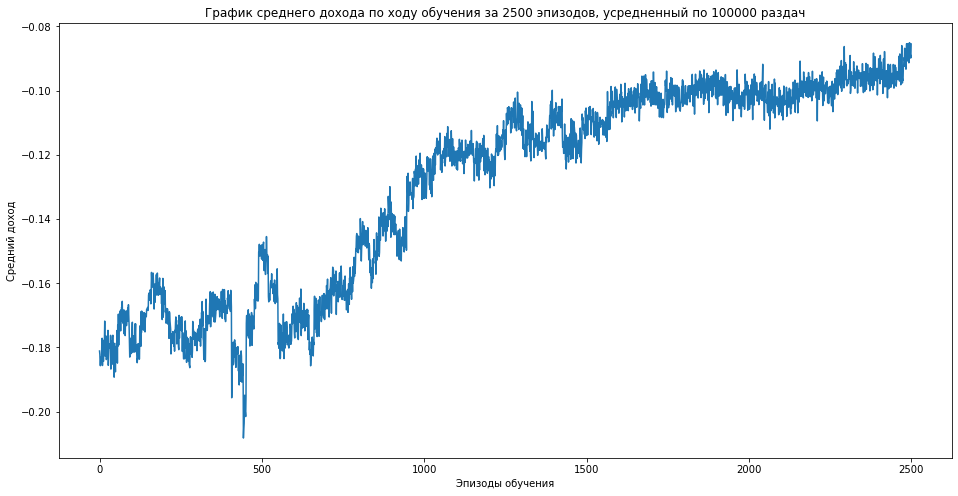

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(n_episodes), rewards_history)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Средний доход')
plt.title(f'График среднего дохода по ходу обучения за {n_episodes} эпизодов, усредненный по {n_draws} раздач')
plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие: <br>
**double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

**Задание:**
1. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
2. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [9]:
from blackjack_with_double import BlackjackEnvWithDouble

In [10]:
# Новая среда с действием double
env = BlackjackEnvWithDouble(natural=True)
actions_double = (0, 1, 2)

states = list(itertools.product(range(4, 32), range(1, 11), (False, True)))
states = [i for i in states if not (i[0] < 12 and i[2])]
states = [i for i in states if not (i[0] > 21 and i[2])]
state_to_index = {s: i for i, s in enumerate(states)}

In [6]:
Q = np.zeros((len(states), len(actions_double)))

Q = q_learning(env, actions_double, Q, n_steps=300000, alpha=0.00001, eps=0.95)
q_policy = get_policy_by_Q(Q)
rew = get_mean_reward(env, q_policy)
print(f'Выигрыш при использовании стратегии double, обученной из Q-learning: {rew}')

100%|██████████| 500000/500000 [00:19<00:00, 25351.51it/s]


Выигрыш при использовании стратегии double, обученной из Q-learning: -0.016986


In [11]:
env = BlackjackEnvWithDouble(natural=True)
n_episodes = 2500
n_draws = 100000
Q = np.zeros((len(states), len(actions_double)))
rewards_history = []

for _ in tqdm(range(n_episodes)):
    Q = q_learning_episode(env, actions_double, Q, alpha=0.00001, eps=0.95)
    policy = get_policy_by_Q(Q)
    reward = get_mean_reward(env, policy, n_steps=n_draws, verbose=False)
    rewards_history.append(reward)

100%|██████████| 2500/2500 [2:54:59<00:00,  4.20s/it]  


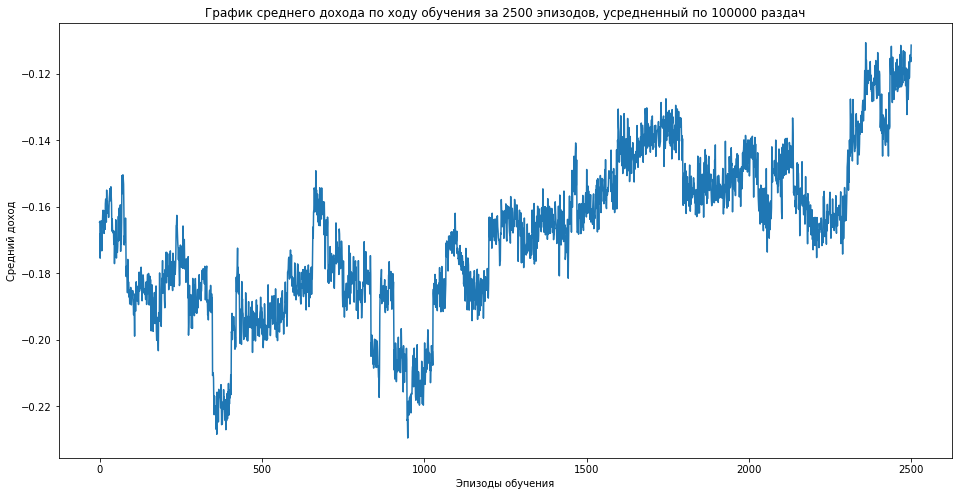

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(n_episodes), rewards_history)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Средний доход')
plt.title(f'График среднего дохода по ходу обучения за {n_episodes} эпизодов, усредненный по {n_draws} раздач')
plt.show()

Добавление действия double позволило увеличить средний доход стратегии. 

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт. Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит.

**Задание:**
1. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
2. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Будем использовать систему "Половинки": <br><br>
**Система «Половинки»** <br><br>
Каждой карте, выходящей из колоды, присваивается своё числовое значение:
![image](https://github.com/viconstel/Advanced-RL-and-DL-hw1/blob/bb42905bd8575bb1113a0a3ae44d4fae0b64b787/card_scores_halves_system.png)

Cумма значений в одной 52-х карточной колоде равна нулю. Возможный диапазон значений от -22 до 22 включительно. Данная сбалансированная система, обладает важным свойством: при положительном счёте шансы игрока **возрастают**, при отрицательном — **падают**. Чем выше счёт, тем больше ожидаемый выигрыш. В каждом состоянии среды теперь будет учитываться текущий счет карт. 

In [183]:
from blackjack_with_halves_counting import BlackjackEnvWithHalves

In [184]:
# Новая среда с действием double и системой подсчета карт "Половинки"
env = BlackjackEnvWithHalves(natural=True)
actions_double = (0, 1, 2)

# В пространство состояний добавится текущая сумма очков при подсчете карт
states = list(itertools.product(range(4, 32), range(1, 11), (False, True), np.arange(-22, 22.5, 0.5)))
states = [i for i in states if not (i[0] < 12 and i[2])]
states = [i for i in states if not (i[0] > 21 and i[2])]
state_to_index = {s: i for i, s in enumerate(states)}

In [185]:
Q = np.zeros((len(states), len(actions_double)))

Q = q_learning(env, actions_double, Q, n_steps=300000, alpha=0.00001, eps=0.95)
q_policy = get_policy_by_Q(Q)
rew = get_mean_reward(env, q_policy)
print(f'Выигрыш стратегии double с системой подсчета "Половинки", обученной из Q-learning: {rew}')

100%|██████████| 500000/500000 [00:59<00:00, 8415.30it/s] 

Выигрыш стратегии double с системой подсчета "Половинки", обученной из Q-learning: -0.054033


Пространство состояний увеличилось в 89 раз, для сходимости модели теперь нужно намного больше итераций, поэтому увеличим число эпизодов обучения хотя бы в 50 раз.

In [186]:
env = BlackjackEnvWithHalves(natural=True)
Q = np.zeros((len(states), len(actions_double)))

Q = q_learning(env, actions_double, Q, n_steps=15_000_000, alpha=0.00001, eps=0.95)
q_policy = get_policy_by_Q(Q)
rew = get_mean_reward(env, q_policy)
print(f'Выигрыш стратегии double с системой подсчета "Половинки", обученной из Q-learning: {rew}')

100%|██████████| 500000/500000 [00:38<00:00, 12921.49it/s]

Выигрыш стратегии double с системой подсчета "Половинки", обученной из Q-learning: -0.007984


In [189]:
env = BlackjackEnvWithHalves(natural=True)
n_episodes = 5000
n_draws = 100000
Q = np.zeros((len(states), len(actions_double)))
rewards_history = []

for _ in tqdm(range(n_episodes)):
    Q = q_learning_episode(env, actions_double, Q, alpha=0.00001, eps=0.95)
    policy = get_policy_by_Q(Q)
    reward = get_mean_reward(env, policy, n_steps=n_draws, verbose=False)
    rewards_history.append(reward)

100%|██████████| 5000/5000 [9:30:11<00:00,  6.84s/it]  


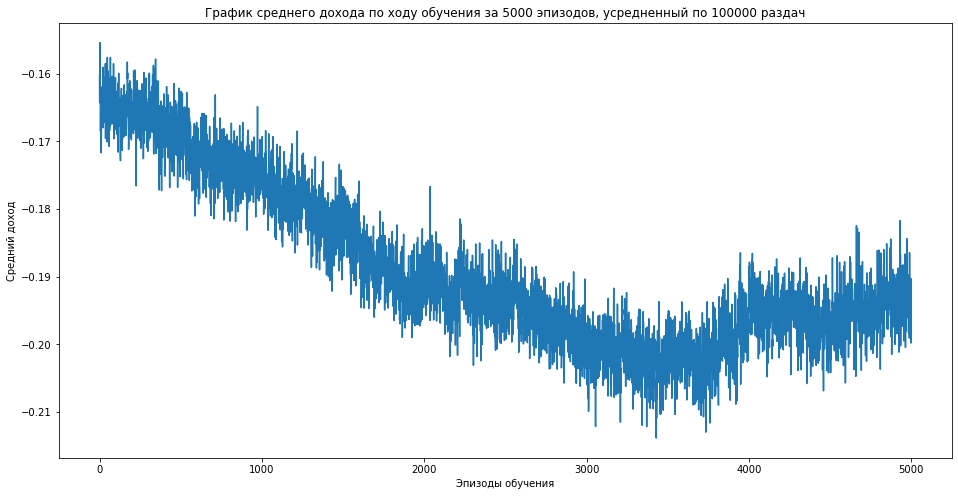

In [190]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(n_episodes), rewards_history)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Средний доход')
plt.title(f'График среднего дохода по ходу обучения за {n_episodes} эпизодов, усредненный по {n_draws} раздач')
plt.show()

Система подсчета карт "Половинки" показала лучшую оценку выигрыша метода, однако обыграть казино до сих пор не удалось. График среднего дохода по ходу обучения не отражает реальной динамики дохода, потому что построен для первых 5000 эпизодов обучения, где модель еще не сходится. Построение графика среднего дохода за большее число эпизодов обучения, усредненного по 100000 раздач, не представляется возможным из-за больших вычислительных затрат.

In [194]:
env = BlackjackEnvWithHalves(natural=True)
n_episodes = 200000
n_draws = 100
Q = np.zeros((len(states), len(actions_double)))
rewards_history = []

for _ in tqdm(range(n_episodes)):
    Q = q_learning_episode(env, actions_double, Q, alpha=0.00001, eps=0.95)
    policy = get_policy_by_Q(Q)
    reward = get_mean_reward(env, policy, n_steps=n_draws, verbose=False)
    rewards_history.append(reward)

100%|██████████| 200000/200000 [26:46<00:00, 124.50it/s]


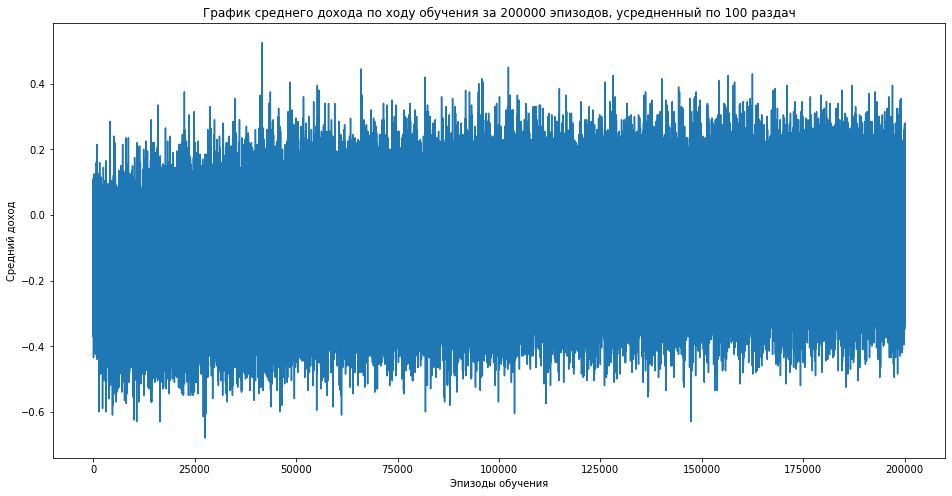

In [195]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(n_episodes), rewards_history)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Средний доход')
plt.title(f'График среднего дохода по ходу обучения за {n_episodes} эпизодов, усредненный по {n_draws} раздач')
plt.show()

In [196]:
import pandas as pd

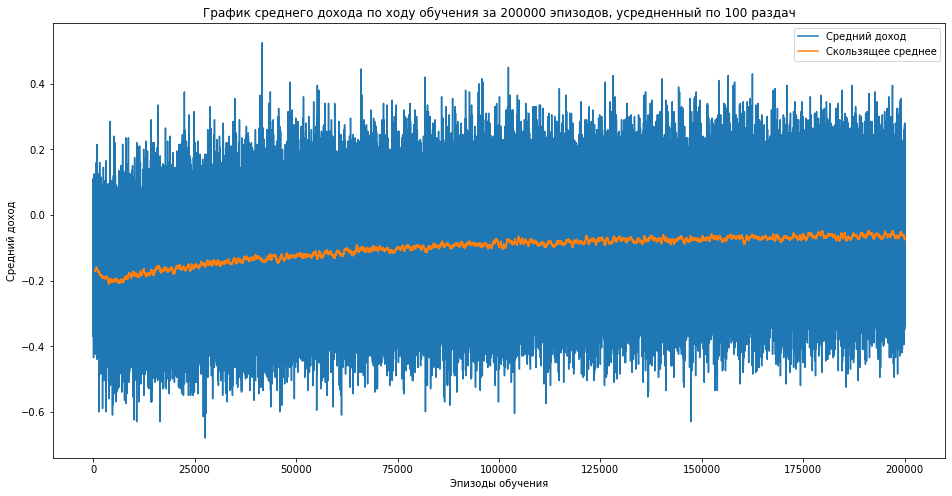

In [214]:
reward_series = pd.Series(rewards_history)
reward_series.plot(figsize=(16, 8), label='Средний доход')
reward_series.rolling(window =500).mean().plot(label='Скользящее среднее')
plt.title(f'График среднего дохода по ходу обучения за {n_episodes} эпизодов, усредненный по {n_draws} раздач')
plt.xlabel('Эпизоды обучения')
plt.ylabel('Средний доход')
plt.legend()

Скользящее среднее по графику среднего дохода по ходу обучения за большее число эпизодов, но меньшее количество раздач для усреднения, позволяет увидеть положительную динамику дохода с увеличением числа эпизодов обучения.